# Import libraries

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import pandas as pd
from modules.models import MLPWithBatchNorm, CustomNormalization
from modules.utils import train_one_epoch, test_one_epoch, isometry_gap, get_measurements
from modules.data_utils import TensorDataLoader, dataset_to_tensors
from constants import ACTIVATIONS, GAINS
from tqdm import tqdm


# Setup configuration

In [49]:
# Configuration setup
config = {
    'dataset': 'MNIST', 
    'num_layers': None, #TBD
    'hidden_dim': 100,
    'batch_size': 512,
    'init_type': None, # TBD
    'norm_type': 'torch_bn',
    'activation': None, # TBD
    'learning_rate': 0.001,
    'order': 'norm_act',  
    'bias': True,
    'mean_reduction': None, # Not needed if we use default pytorch BN
    'force_factor': None, # Not needed if we use default pytorch BN
    'gain_exponent': -0.5,
    'num_epochs': 200
}


# Load dataset


In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ds = getattr(torchvision.datasets, config['dataset'])
transform = torchvision.transforms.ToTensor()  # Replace with actual transform
trainset = ds(root='../Data', train=True, download=True, transform=transform)
testset = ds(root='../Data', train=False, download=True, transform=transform)

trainloader = TensorDataLoader(*dataset_to_tensors(trainset, device=device), batch_size=config['batch_size'], shuffle=True)
testloader = TensorDataLoader(*dataset_to_tensors(testset, device=device), batch_size=config['batch_size'], shuffle=False)


# To run all night

In [50]:
# Define the combinations of parameters
combinations = [
    
    ('orthogonal', 100, 'identity'),
    ('orthogonal', 100, 'tanh'),
    ('orthogonal', 100, 'sin'),
    
    ('orthogonal', 1000, 'identity'),
    ('orthogonal', 1000, 'tanh'),
    ('orthogonal', 1000, 'sin'),

    # ('orthogonal', 500, 'identity'),    
    # ('orthogonal', 500, 'tanh'),
    # ('orthogonal', 500, 'sin'),


]

save_path = 'training/mnist/'

for init_type, num_layers, activation in combinations:
    # Update the config dictionary with the current combination
    config['init_type'] = init_type
    config['num_layers'] = num_layers
    config['activation'] = activation

    # Instantiate the model with the updated configuration
    model = MLPWithBatchNorm(
        input_dim=1*28*28,  # Adjust for your dataset
        output_dim=10,      # Number of classes in your dataset
        num_layers=config['num_layers'],
        hidden_dim=config['hidden_dim'],
        norm_type=config['norm_type'],
        mean_reduction=config['mean_reduction'],
        activation=ACTIVATIONS[config['activation']],
        save_hidden=False,
        exponent=config['gain_exponent'],
        order=config['order'],
        force_factor=config['force_factor'],
        bias=config['bias']
    ).to(device)

    model.reset_parameters(config['init_type'])


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])
    
    # Training loop
    df = []
    progress_bar = tqdm(range(1, config['num_epochs'] + 1), desc="Training")
    for epoch in progress_bar:
        train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
        test_loss, test_acc = test_one_epoch(model, testloader, criterion, device)
        
        df.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
        })
        progress_bar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Save the results
    results_df = pd.DataFrame(df)
    save_name = f'mnist_d{num_layers}_{activation}_{init_type}.csv'
    results_df.to_csv(save_path + save_name)


Epoch: 200, Train Loss: 0.9779, Train Acc: 0.8690, Test Loss: 1.0792, Test Acc: 0.8785: 100%|██████████| 200/200 [08:50<00:00,  2.65s/it]
Epoch: 200, Train Loss: 0.6709, Train Acc: 0.9466, Test Loss: 0.7109, Test Acc: 0.9456: 100%|██████████| 200/200 [09:30<00:00,  2.85s/it]
Epoch: 200, Train Loss: 0.7190, Train Acc: 0.9364, Test Loss: 0.7737, Test Acc: 0.9408: 100%|██████████| 200/200 [09:37<00:00,  2.89s/it]
Epoch: 200, Train Loss: 1.9982, Train Acc: 0.7795, Test Loss: 2.2263, Test Acc: 0.3892: 100%|██████████| 200/200 [1:17:51<00:00, 23.36s/it]
Epoch: 200, Train Loss: 1.9606, Train Acc: 0.8580, Test Loss: 2.1163, Test Acc: 0.7871: 100%|██████████| 200/200 [1:23:41<00:00, 25.11s/it]
Epoch: 200, Train Loss: 1.9646, Train Acc: 0.8464, Test Loss: 2.1617, Test Acc: 0.7077: 100%|██████████| 200/200 [1:29:53<00:00, 26.97s/it]


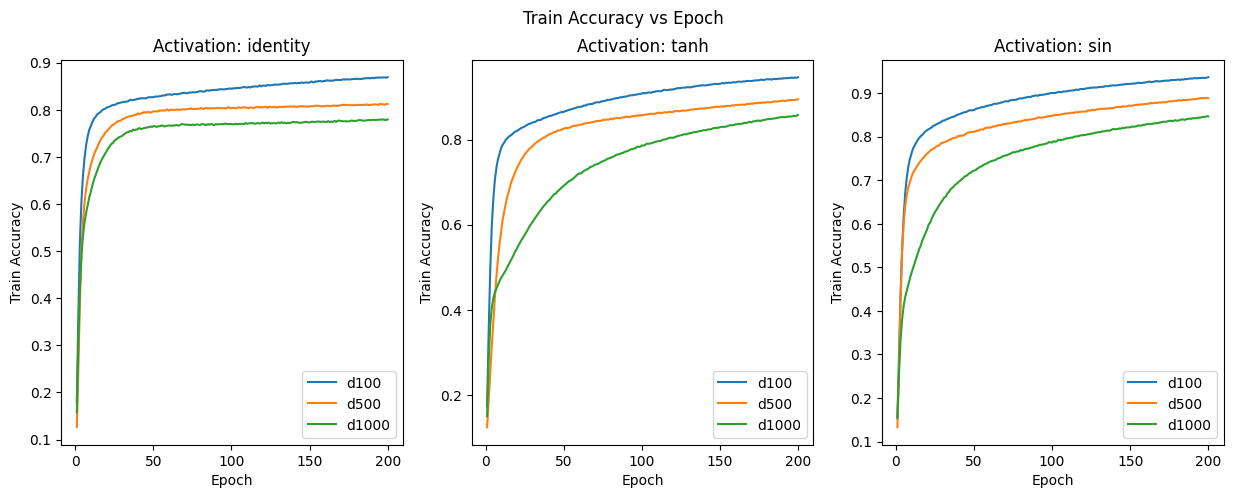

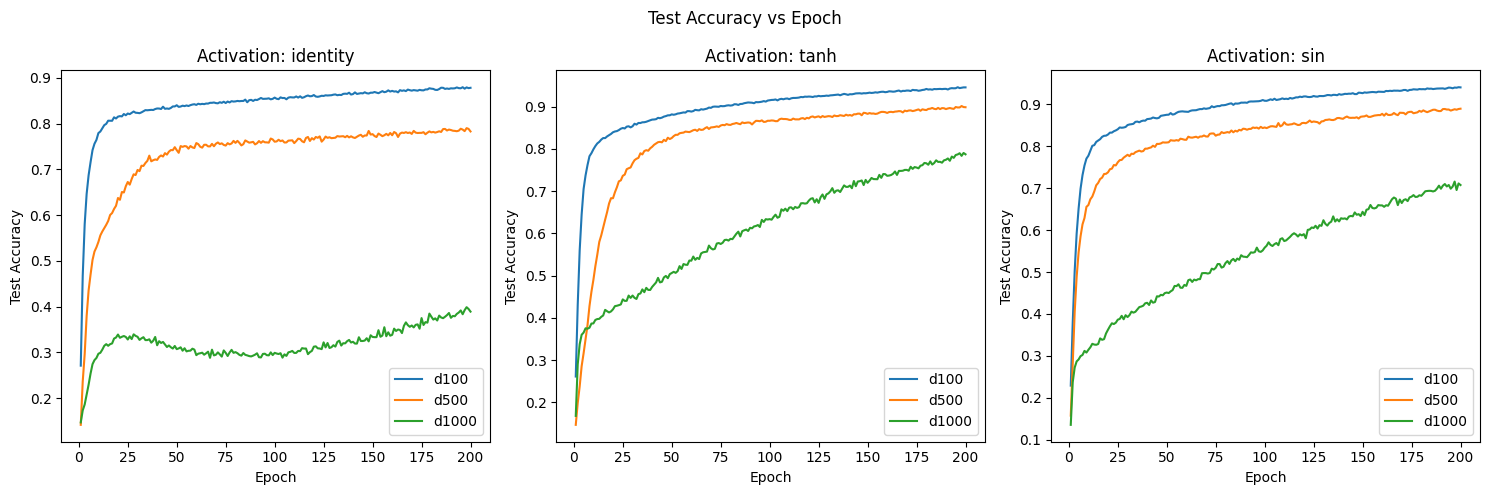

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Define file names
files = {
    "identity": [
        "mnist_d100_identity_orthogonal.csv",
        "mnist_d500_identity_orthogonal.csv",
        "mnist_d1000_identity_orthogonal.csv",
    ],
    "tanh": [
        "mnist_d100_tanh_orthogonal.csv",
        "mnist_d500_tanh_orthogonal.csv",
        "mnist_d1000_tanh_orthogonal.csv",
    ],
    "sin": [
        "mnist_d100_sin_orthogonal.csv",
        "mnist_d500_sin_orthogonal.csv",
        "mnist_d1000_sin_orthogonal.csv",
    ]
}

# Initialize the figure for train accuracy
fig_train, axes_train = plt.subplots(1, 3, figsize=(15, 5))
fig_train.suptitle("Train Accuracy vs Epoch")

# Initialize the figure for test accuracy
fig_test, axes_test = plt.subplots(1, 3, figsize=(15, 5))
fig_test.suptitle("Test Accuracy vs Epoch")

# Loop through each activation function and its corresponding files
for idx, (activation, file_list) in enumerate(files.items()):
    for file in file_list:
        # Load data
        df = pd.read_csv(f"training/mnist/{file}")

        # Plot train accuracy
        axes_train[idx].plot(df['epoch'], df['train_acc'], label=file.split('_')[1])
        axes_train[idx].set_title(f"Activation: {activation}")
        axes_train[idx].set_xlabel("Epoch")
        axes_train[idx].set_ylabel("Train Accuracy")
        axes_train[idx].legend()
        #axes_train[idx].set_xscale('log')  # Logarithmic scale for x-axis

        # Plot test accuracy
        axes_test[idx].plot(df['epoch'], df['test_acc'], label=file.split('_')[1])
        axes_test[idx].set_title(f"Activation: {activation}")
        axes_test[idx].set_xlabel("Epoch")
        axes_test[idx].set_ylabel("Test Accuracy")
        axes_test[idx].legend()
        #axes_test[idx].set_xscale('log')  # Logarithmic scale for x-axis

plt.tight_layout()
plt.show()
